In [1]:
import glob
from hera_cal import abscal
from hera_cal import io, utils
import copy
import numpy as np
from pathlib import Path
import os
import time

In [2]:
DATA_FILE = "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
ABSCAL_MIN_BL_LEN = 0
ABSCAL_MAX_BL_LEN =np.inf

In [3]:
Path(DATA_FILE).exists()

True

In [4]:
hd = io.HERAData(DATA_FILE)

In [5]:
abscal_model_files = sorted(
    glob.glob("/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.?????.uvh5")
)
print(f'Found {len(abscal_model_files)} abscal model files{" in " + os.path.dirname(abscal_model_files[0]) if len(abscal_model_files) > 0 else ""}.')

Found 35 abscal model files in /safepool/rbyrne/hera_data/H4C-Abscal-Model.


In [6]:
abscal_start = time.time()
# figure out which model files match the LSTs of the data
matched_model_files = sorted(set(abscal.match_times(DATA_FILE, abscal_model_files, filetype='uvh5')))

# figure out appropriate model times to load
hdm = io.HERAData(matched_model_files)
all_model_times, all_model_lsts = abscal.get_all_times_and_lsts(hdm, unwrap=True)
d2m_time_map = abscal.get_d2m_time_map(hd.times, np.unwrap(hd.lsts), all_model_times, all_model_lsts, extrap_limit=.5)

In [7]:

# load matching times and baselines
#unflagged_data_bls = [bl for bl in vissol_flags if not np.all(vissol_flags[bl]) and bl[2] == pol]
unflagged_data_bls = hd.bls
data_bls = hd.bls

model_bls = copy.deepcopy(hdm.bls)
model_antpos = hdm.data_antpos

if len(matched_model_files) > 1:  # in this case, it's a dictionary
    model_bls = list(set([bl for bls in list(hdm.bls.values()) for bl in bls]))
    model_antpos = {ant: pos for antpos in hdm.data_antpos.values() for ant, pos in antpos.items()}

data_bls, model_bls, data_to_model_bl_map = abscal.match_baselines(
    unflagged_data_bls, model_bls, hd.antpos, model_antpos=model_antpos, 
    data_is_redsol=True, model_is_redundant=True, tol=1.0,
    min_bl_cut=ABSCAL_MIN_BL_LEN, max_bl_cut=ABSCAL_MAX_BL_LEN, verbose=True
)

model, model_flags, _ = io.partial_time_io(hdm, np.unique([d2m_time_map[time] for time in hd.times]), bls=model_bls)
model_bls = [data_to_model_bl_map[bl] for bl in data_bls]

# rephase model to match in lsts
model_blvecs = {bl: model.antpos[bl[0]] - model.antpos[bl[1]] for bl in model.keys()}
utils.lst_rephase(
    model, model_blvecs, model.freqs, hd.lsts - model.lsts,
    lat=hdm.telescope_location_lat_lon_alt_degrees[0], inplace=True
)

Selected 834 data baselines and 834 model baselines to load.


In [8]:
import matplotlib.pyplot as plt

In [9]:
model.freqs.size

1536

In [10]:
model.times

array([2458894.09853819, 2458894.09865004])

In [12]:
flags[(116, 10, 'ee')]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
data, flags, _ = hd.read()

In [13]:
len(model_bls)

834

In [14]:
len(data_bls)

834

(58, 22, 'nn') (196, 141, 'nn') [-73.20025961  41.89373401  -0.40924963] [-73.20020634  41.88372862  -0.4015369 ]
(107, 22, 'nn') (250, 143, 'nn') [-80.64911062  79.81624063  -0.73903083] [-80.6490466   79.80622714  -0.75173892]
(166, 5, 'nn') (316, 166, 'nn') [ 21.44471591 122.37942524  -1.02897979] [ 21.44476157 122.36937122  -1.20140898]
(3, 21, 'nn') (295, 314, 'nn') [-9.49026677e+01 -1.30094239e+01  8.95823993e-02] [-9.49026437e+01 -1.30093954e+01  4.92838161e-02]
(98, 158, 'ee') (135, 197, 'ee') [-29.05463897 -42.28424394   0.58934583] [-29.05467359 -42.27423459   0.38944688]
(118, 3, 'ee') (308, 185, 'ee') [-73.4256909  100.92547884  -1.02017153] [-73.42566563 100.92544511  -0.8521213 ]
(54, 3, 'nn') (308, 253, 'nn') [-14.80110721  50.55142522  -0.4594805 ] [-14.80109318  50.55140306  -0.3410925 ]
(53, 3, 'nn') (308, 254, 'nn') [-29.40894826  50.49563762  -0.45967165] [-29.40893073  50.49561732  -0.36128364]
(161, 36, 'nn') (266, 135, 'nn') [43.46921267 92.94723932 -0.92889673] 

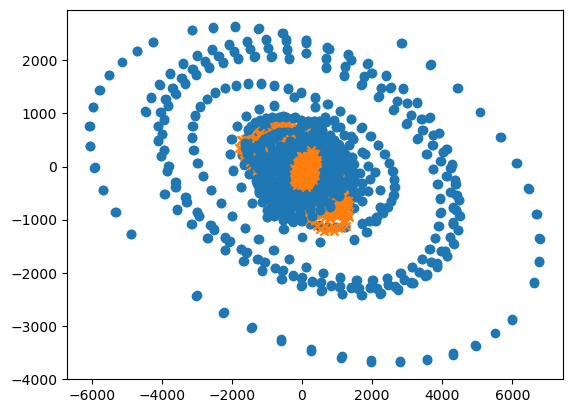

In [15]:
for dbl, mbl in zip(data_bls[::100], model_bls[::100]):
    print(dbl, mbl, hd.antpos[dbl[0]] - hd.antpos[dbl[1]], hd.antpos[mbl[0]] - hd.antpos[mbl[1]])
    mdl = np.where(flags[dbl], np.nan, model[mbl])
    d = np.where(flags[dbl], np.nan, data[dbl])
    plt.scatter(mdl.real.flatten(), mdl.imag.flatten(), color='C0')
    plt.scatter(d.real.flatten(), d.imag.flatten(), color='C1', marker='x')

(128, 7, 'ee')


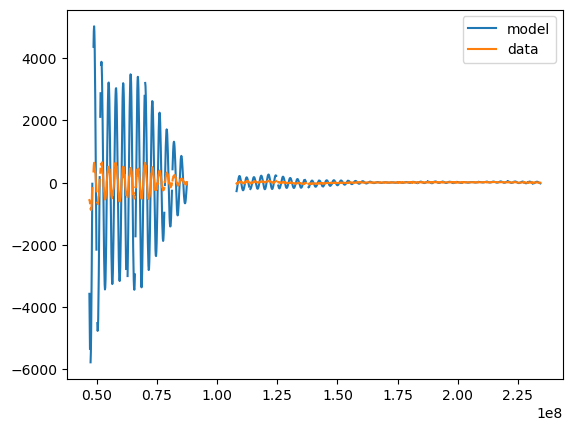

In [16]:
for dbl, mbl in zip(data_bls, model_bls):
    if np.all(flags[dbl][0]) or dbl[2][0] != dbl[2][1]:
        continue
        
    #print(dbl, mbl, hd.antpos[dbl[0]] - hd.antpos[dbl[1]], hd.antpos[mbl[0]] - hd.antpos[mbl[1]])
    plt.plot(hd.freqs, np.where(flags[dbl], np.nan, model[mbl])[0].real, color='C0', label='model')
    plt.plot(hd.freqs, np.where(flags[dbl], np.nan, data[dbl])[0].real, color='C1', label='data')
    plt.legend()
    # plt.scatter(data[dbl].real.flatten(), data[dbl].imag.flatten(), color='C1', marker='x')
    print(dbl)
    break

In [ ]:
data[(143, 3, 'ee')]

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])